imports

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import string

Load CSVs into DataFrames

In [100]:
# path to cleaned resume file
lightsail_resume_cleaned_path = '/home/ec2-user/NLP_projects/job_recommender_project/data/cleaned_resume_dataset_maitrip.csv'
local_resume_cleaned_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/data/cleaned_resume_dataset_maitrip.csv'
# resume_cleaned_path = lightsail_jobs_cleaned_path
resume_cleaned_path = local_resume_cleaned_path

# load cleaned jobs to df
resumes = pd.read_csv(resume_cleaned_path)
resumes.head()

,ID,Category,dirty_resume,resume
0,1,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...",john h smith phr po box callahan fl infog...
1,2,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...,name surname address mobile noemail personal p...
2,3,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...,anthony brown hr assistant areas expertise per...
3,4,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...,satheesh email id career objective pursue gro...
4,5,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert...",human resources director expert organizational...


In [101]:
# path to cleaned jobs file
lightsail_jobs_cleaned_path = '/home/ec2-user/NLP_projects/job_recommender_project/data/cleaned_job_posts_madhab.csv'
local_jobs_cleaned_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/data/cleaned_job_posts_madhab.csv'
# jobs_cleaned_path = lightsail_jobs_cleaned_path
jobs_cleaned_path = local_jobs_cleaned_path

#load cleaned resumes to df
jobs = pd.read_csv(jobs_cleaned_path)
jobs.head()

,Title,Company,JobDescription,RequiredQual,JobRequirement,label,combined,dirty_combined
0,Chief Financial Officer,AMERIA Investment Consulting Company,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\r\nindivi...",- Supervises financial management and administ...,1,chief financial officer ameria investment cons...,Chief Financial Officer AMERIA Investment Cons...
1,Country Coordinator,Caucasus Environmental NGO Network (CENN),Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",- Working with the Country Director to provide...,2,country coordinator public outreach strengthen...,Country Coordinator Public outreach and streng...
2,BCC Specialist,Manoff Group,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",- Identify gaps in knowledge and overseeing in...,3,bcc specialist lead local enhancement developm...,BCC Specialist The LEAD (Local Enhancement and...
3,"Community Development, Capacity Building and C...",Food Security Regional Cooperation and Stabili...,Food Security Regional Cooperation and Stabili...,- Higher Education and/or professional experie...,- Assist the Tavush Marz communities and commu...,4,community development capacity building confli...,"Community Development, Capacity Building and C..."
4,Country Economist (NOB),"United Nations Development Programme, Armenia",The United Nations Development Programme in Ar...,- Minimum Masters Degree in Economics;\r\n- Mi...,The incumbent under direct supervision of UNDP...,5,country economist nob united nations developme...,Country Economist (NOB) The United Nations Dev...


<br><br><br><br><br>

# Gensim Doc2Vec on Jobs



In [102]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk import word_tokenize

In [103]:
# for i in jobs_test['combined']:
#     jobs_test['label'] = jobs_test['combined'].index
# for i in jobs_train['combined']:
#     jobs_train['label'] = jobs_train['combined'].index


In [104]:
# # see labels applied
# jobs_train.head()

In [105]:
# TaggedDocumentIterator class takes pandas text and label Series and yields TaggedDocuments
class TaggedDocumentIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield TaggedDocument(words=doc.split(), tags=[self.labels_list[idx]])
 
docLabels = list(jobs['label'])
jobs_data = list(jobs['combined'])
jobs_sentences = TaggedDocumentIterator(jobs_data, docLabels)

Model will take a few min to train on laptop

In [106]:
# train Doc2Vec model on jobs

d2v_jobs_model = Doc2Vec(vector_size=100, window=10, min_count=5, workers=11,alpha=0.025, epochs=20)
d2v_jobs_model.build_vocab(jobs_sentences)
d2v_jobs_model.train(jobs_sentences,total_examples=d2v_model.corpus_count, epochs=d2v_model.iter)

/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [107]:
# Store the d2v jbos model to file
lightsail_d2v_model_path = '/home/ec2-user/NLP_projects/job_recommender_project/models/d2v_model_jobs.doc2vec'
local_d2v_model_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v_model_jobs.doc2vec'

# save_path = lightsail_d2v_model_path
d2v_jobs_save_path = local_d2v_model_path


In [108]:
#save the model
d2v_jobs_model.save(d2v_jobs_save_path)


In [109]:
#load model
d2v_jobs_model = Doc2Vec.load(d2v_jobs_save_path)




In [110]:
type(d2v_jobs_model.docvecs)

gensim.models.keyedvectors.Doc2VecKeyedVectors

# START HERE AGAIN


credit: https://praveenbezawada.com/2018/01/25/document-similarity-using-gensim-dec2vec/

In [111]:
# def resume_test_predict(pick_a_resume_number):
def given_resume_predict_jobs():
    print("There are {} resumes\n".format(resumes.shape[0]))
    
    # Select a random int from 0 to length of resume set
    rand_int = np.random.randint(1, resumes.shape[0]+1)
    # selection = pick_a_resume_number
    selection = rand_int
    print ('selected resume is ID #{}\n'.format(selection))
    
    # pick the resume text and ID associated with the random int
    pick_text = resumes.iloc[selection -1 ]['resume']
    pick_label = resumes.iloc[selection -1, resumes.columns.get_loc('ID')] #we could grab ID, but this works for non-indexed labels too
    print('Resume ID is: {}'.format(pick_label))
    print('Resume text: {}'.format(pick_text))
    
    ####I didn't do his cleaning because I did my own. Need cleaning maybe on other stuff?
    #Clean the document using the utility functions used in train phase
    #test_sample = default_clean(test_sample)
    #test_sample = stop_and_stem(test_sample, stem=False)
 
    #Convert the sample document into a list and use the infer_vector method to get a vector representation for it
    pick_words = pick_text.split()
    pick_vec = d2v_jobs_model.infer_vector(pick_words, steps=50, alpha=0.25)
    #print('split words is: {}'.format(pick_words))
    #print('vector is: {}'.format(pick_vec))
 
    #use the most_similar utility to find the most similar documents.
    similars = d2v_jobs_model.docvecs.most_similar(positive=[pick_vec])
 
    print('\n\n\t\tSimilar job descriptions to this resume:')
    
    count = 1
    for i in similars:
        print('\nSimilar job number: {}'.format(count))
        count += 1
        print('Job ID ', i[0], ' Similarity Score: ', i[1])
        
        # pulls combined text from jobs_train 
        #print(jobs_train.iloc[i[0]]['combined'],  '\n')

        # pulls job title and description from jobs.txt
        print('Job title: {}'.format(jobs.iloc[i[0]]['Title']))
        print('Company: {}'.format(jobs.iloc[i[0]]['Company']))
        print('Description: {}'.format(jobs.iloc[i[0]]['JobDescription']))
        
        


In [129]:
given_resume_predict_jobs()

There are 1219 resumes

selected resume is ID #460

Resume ID is: 460
Resume text: technical business analyst consultant resume professional summary highly motivated employee  years experience coordinating complex projects issues across organizational boundaries business analyst provide support project team analysis documentation business needs ensuring accurate alignment technology business objectives experienced business analysis cross system integration analysis data analysis use case analysis requirements elicitation gap analysis configuration change management process engineering design testing problem solving project management liaison experience customer consultant facilitatinag business process integration efforts diverse groups communication technical concepts non technical audiences joint collaboration business technical environments jad facilitator experience managing implementing systems new products processes enhancement current products processes leveraging industry stand

# Given job, find similar resumes:

In [113]:
# TaggedDocumentIterator class takes pandas text and label Series and yields TaggedDocuments
class TaggedDocumentIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield TaggedDocument(words=doc.split(), tags=[self.labels_list[idx]])
 


In [114]:
# make TaggedDocuments from resumes dataframe to then create d2v model
resumes_labels = list(resumes['ID'].astype(str))
resumes_data = list(resumes['resume'].astype(str))
resumes_sentences = TaggedDocumentIterator(resumes_data, resumes_labels)

Model will take a few min to train on laptop

In [115]:
# train Doc2Vec model on jobs

d2v_resume_model = Doc2Vec(vector_size=100, window=10, min_count=5, workers=11,alpha=0.025, epochs=20)
d2v_resume_model.build_vocab(resumes_sentences)
d2v_resume_model.train(resumes_sentences,total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)



In [116]:
# Store the d2v jbos model to file
lightsail_d2v_resume_model_path = '/home/ec2-user/NLP_projects/job_recommender_project/models/d2v_model_resumes.doc2vec'
local_d2v_resume_model_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v_model_resumes.doc2vec'

# d2v_resume_save_path = lightsail_d2v_resume_model_path
d2v_resume_save_path = local_d2v_resume_model_path


In [117]:
#save the model
d2v_resume_model.save(d2v_resume_save_path)


In [118]:
#load model
d2v_resume_model = Doc2Vec.load(d2v_resume_save_path)




In [119]:
type(d2v_resume_model.docvecs)

gensim.models.keyedvectors.Doc2VecKeyedVectors

In [133]:
# def resume_test_predict(pick_a_resume_number):
def given_job_predict_similiar_resumes():
    print("There are {} jobs\n".format(jobs.shape[0]))
    
    # Select a random int from 0 to length of rjob set
    rand_int = np.random.randint(1, jobs.shape[0]+1)
    # selection = pick_a_job_number
    selection = rand_int
    print ('selected job is ID #{}\n'.format(selection))
    
    # pick the job text and ID associated with the random int
    pick_text = jobs.iloc[selection -1 ]['combined']
    pick_label = jobs.iloc[selection -1, jobs.columns.get_loc('label')] #we could grab ID, but this works for non-indexed labels too
    print('Resume ID is: {}'.format(pick_label))
    print('Resume text: {}'.format(pick_text))
    
    #Convert the sample document into a list and use the infer_vector method to get a vector representation for it
    pick_words = pick_text.split()
    pick_vec = d2v_resume_model.infer_vector(pick_words, steps=50, alpha=0.25)
    #print('split words is: {}'.format(pick_words))
    #print('vector is: {}'.format(pick_vec))
 
    #use the most_similar utility to find the most similar documents.
    similars = d2v_resume_model.docvecs.most_similar(positive=[pick_vec])
    
    
    # print('\n\nsimilars are: ', similars)
    
 
    print('\n\n\t\t\t\tSimilar candidates for this job:')
    
    count = 1
    for i in similars:
        print('\nSimilar resume number: {}'.format(count))
        count += 1
        print('Resume label ', i[0], ' Similarity Score: ', i[1])
        
        # pulls combined text from jobs_train 
        #print(jobs_train.iloc[i[0]]['combined'],  '\n')

        # pulls candidate name, info, text
        print('Candidate resume: {}'.format(resumes.iloc[int(i[0])]['resume']))
#         print('Resume: {}'.format(resumes.iloc[i[0]]['Company']))
#         print('Description: {}'.format(resumes.iloc[i[0]]['JobDescription']))
        
        


In [134]:
given_job_predict_similiar_resumes()

There are 13124 jobs

selected job is ID #3035

Resume ID is: 3035
Resume text: director public programs director public programs senior level staff position reports directly centers deputy director executive director director public programs responsible coordinating developing programming taking place centers new cinema jazz lounge addition director also responsible overseeing staff dedicated food beverage service rental spaces inside center perform responsibilities position effectively successful applicant must able perform multiple tasks manage large staff budget effectively conversant variety cultural endeavors including film video art manage funds make reports centers finance department organize supervise activities connected centers film series jazz concerts includes planning scheduling promoting implementing events organize programming take place periodically tamanian park responsible yearly event planning calendar related budget supervise planning organizational activities banq

resume 1057: xefxxaxefxxaxefxxaxefxxaxefxxaxefxxaxefxxaxefxxaxefxxa xefxxxefxxaxefxxaxefxxaxefxxaxefxxaxefxxaxefxxa
resume 1057 xc xefxxaxefxxaxefxxaxefxxaxefxxaxefxxaxefxxaxefxxaxefxxa

<br>
<br>
<br>
<br>
<br>

# K Means Clustering
Appears that our embeddings are pretty close together. So either the resumes are similar or the embeddings aren't great

https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61

In [122]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### KMeans for job vectors

/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  if __name__ == '__main__':
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  # Remove the CWD from sys.path while we load stuff.
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  # This is added back by InteractiveShellApp.init_path()


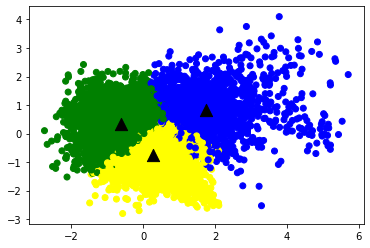

In [137]:
# define number of clusters here
kmeans_jobs_model = KMeans(n_clusters=3) 


X = kmeans_jobs_model.fit(d2v_jobs_model.docvecs.doctag_syn0)
labels=kmeans_jobs_model.labels_.tolist()


l = kmeans_jobs_model.fit_predict(d2v_jobs_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_jobs_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_jobs_model.docvecs.doctag_syn0)

plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_jobs_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

### KMeans for resumes

/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  if __name__ == '__main__':
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  # Remove the CWD from sys.path while we load stuff.
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  # This is added back by InteractiveShellApp.init_path()


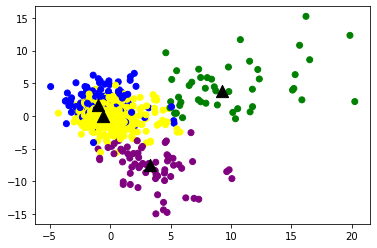

In [141]:
# define number of clusters here
kmeans_resumes_model = KMeans(n_clusters=4) 


X = kmeans_resumes_model.fit(d2v_resume_model.docvecs.doctag_syn0)
labels=kmeans_resumes_model.labels_.tolist()


l = kmeans_resumes_model.fit_predict(d2v_resume_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_resume_model.docvecs.doctag_syn0)
resume_datapoint = pca.transform(d2v_resume_model.docvecs.doctag_syn0)

plt.figure
label2 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
color = [label2[i] for i in labels]
plt.scatter(resume_datapoint[:, 0], resume_datapoint[:, 1], c=color)

resume_centroids = kmeans_resumes_model.cluster_centers_
resume_centroidpoint = pca.transform(resume_centroids)
plt.scatter(resume_centroidpoint[:, 0], resume_centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()